<a href="https://colab.research.google.com/github/sammainahkinya1404/East-Africa-Young-Researchers-School-of-Advanced-Machine-Learning-2025/blob/main/Copy_of_Session_7_demo_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of transfert learning with CIFAR-10 dataset and the model VGG16 trained on ImageNet database

In [ ]:
# Import librairies
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

## Preparation of CIFAR-10 dataset

In [ ]:
# Define a sequence of transforms to convert the image to a PyTorch tensor and normalize it.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

In [ ]:
# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)# DataLoader for batching and shuffling

# Define the number of images for the subset
subset_size = 300
all_indices = torch.randperm(len(train_dataset))  # mixed indices
train_indices = all_indices[:subset_size]     # keep only subset_size
test_indices = torch.randperm(len(test_dataset))[:150] # just half of the images for the test

# Keep a small subset of the dataset
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

BATCH_SIZE = 64 # Define the number of samples per batch

# Turn datasets into iterables (batches)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

# Display the name of the 10 classes
train_dataset.classes

100%|██████████| 170M/170M [00:02<00:00, 72.3MB/s]


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

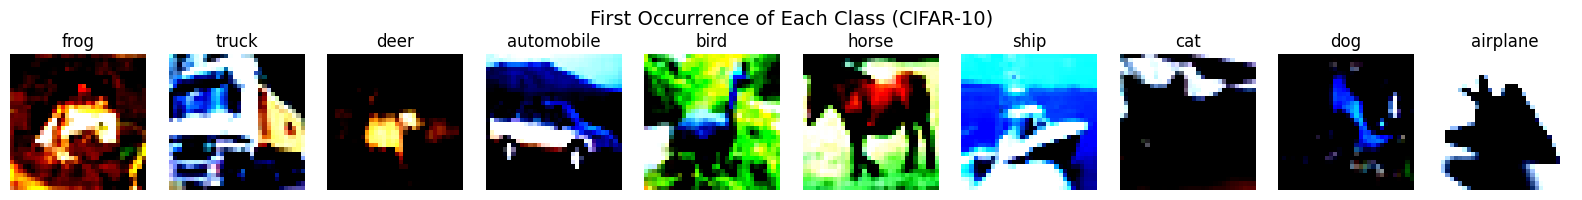

In [ ]:
# Visualization of the 10 class
fig, axs = plt.subplots(1, 10, figsize=(16, 2))
fig.suptitle("First Occurrence of Each Class (CIFAR-10)", fontsize=14)

seen_classes = set()
shown = 0

for img_disp, lbl in train_dataset:
    if lbl not in seen_classes:
        #img_disp = unnormalize(img)  # undo normalization if needed
        img_disp = img_disp.permute(1, 2, 0).clamp(0, 1).numpy()  # CxHxW -> HxWxC
        axs[shown].imshow(img_disp)
        axs[shown].set_title(train_dataset.classes[lbl])
        axs[shown].axis("off")
        seen_classes.add(lbl)
        shown += 1
    if shown == 10:
        break

plt.tight_layout()
plt.show()

## Load and modify the pre-trained VGG16 model

In [ ]:
# Load pre-trained VGG16 model with trained model weights on ImageNet
# available weights are listed on the PyTorch website
# https://docs.pytorch.org/vision/stable/models.html
model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
# Display the structure of the model
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We need to modify the last layer so that it corresponds to the number of classes in our task, i.e. 10 classes on CIFAR-10 (compared with 1,000 classes for the model pre-trained on ImageNet). The structure of the model is described in the print. We can see that the last layer is #6 of the `classifier`.

In [ ]:
# Modify the classifier for CIFAR-10 (10 classes)
model.classifier[6] = nn.Linear(in_features=4096, out_features=10)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layers of the classifier to adapt their weight during training
for param in model.classifier.parameters():
    param.requires_grad = True

# Train the model

In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) # Small learning rate

# Training loop
epochs = 15
for epoch in range(epochs):
    # Set the model to training mode
    model.train()

    # Empty variables for store metrics values
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through batches of training data
    for inputs, labels in train_loader:

        # Move variables to the device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Perform a forward pass to get model outputs (predictions)
        loss = criterion(outputs, labels) # Calculate the loss between the model outputs and the true labels
        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on the calculated gradients

        running_loss += loss.item() # Add the current batch's loss to the running total loss
        _, predicted = outputs.max(1) # Get the index (class label) of the highest scoring prediction for each example
        correct += predicted.eq(labels).sum().item() # Compare predicted labels with true labels and count how many are correct
        total += labels.size(0) # Add the number of samples in this batch to the total number of processed sample

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/15], Loss: 8.3008, Accuracy: 8.67%
Epoch [2/15], Loss: 2.9426, Accuracy: 44.33%
Epoch [3/15], Loss: 2.4795, Accuracy: 53.00%
Epoch [4/15], Loss: 1.5613, Accuracy: 61.33%
Epoch [5/15], Loss: 1.1425, Accuracy: 67.67%
Epoch [6/15], Loss: 1.0170, Accuracy: 76.33%
Epoch [7/15], Loss: 0.9784, Accuracy: 79.67%
Epoch [8/15], Loss: 0.6405, Accuracy: 81.67%
Epoch [9/15], Loss: 0.5612, Accuracy: 84.33%
Epoch [10/15], Loss: 0.4550, Accuracy: 88.33%
Epoch [11/15], Loss: 0.5769, Accuracy: 86.33%
Epoch [12/15], Loss: 0.3978, Accuracy: 90.00%
Epoch [13/15], Loss: 0.3289, Accuracy: 90.67%
Epoch [14/15], Loss: 0.3303, Accuracy: 93.00%
Epoch [15/15], Loss: 0.3695, Accuracy: 91.33%


# Evaluate the model

In [ ]:
# Evaluate the Model

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 46.67%


# Training from scratch
For comparison, we can try training the same dataset on the model from scratch, i.e. without retrieving the trained weights from ImageNet.

In [ ]:
# Load the model without the weights
model_from_scratch = torchvision.models.vgg16(weights=None)

# Modify the classifier for CIFAR-10 (10 classes)
model_from_scratch.classifier[6] = nn.Linear(in_features=4096, out_features=10)

# Move model on device
model_from_scratch = model_from_scratch.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_from_scratch.classifier.parameters(), lr=0.001) # Small learning rate

# Training loop
epochs = 5
for epoch in range(epochs):
    # Set the model to training mode
    model_from_scratch.train()

    # Empty variables for store metrics values
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate through batches of training data
    for inputs, labels in train_loader:

        # Move variables to the device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_from_scratch(inputs)  # Perform a forward pass to get model outputs (predictions)
        loss = criterion(outputs, labels) # Calculate the loss between the model outputs and the true labels
        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on the calculated gradients

        running_loss += loss.item() # Add the current batch's loss to the running total loss
        _, predicted = outputs.max(1) # Get the index (class label) of the highest scoring prediction for each example
        correct += predicted.eq(labels).sum().item() # Compare predicted labels with true labels and count how many are correct
        total += labels.size(0) # Add the number of samples in this batch to the total number of processed sample

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model
model_from_scratch.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_from_scratch(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 4.0441, Accuracy: 9.67%
Epoch [2/5], Loss: 2.3696, Accuracy: 10.67%
Epoch [3/5], Loss: 2.3072, Accuracy: 11.33%
Epoch [4/5], Loss: 2.3207, Accuracy: 9.67%
Epoch [5/5], Loss: 2.3084, Accuracy: 13.67%
Test Accuracy: 12.67%


# Hands-on practice
By groupe, work on the fruits dataset you created earlier and train it from learning transfer. You can test other models if you wish, or include data augmentation.